# Imports

In [514]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error

# Read Data

In [515]:
df = pd.read_csv('../02_analysis/df_good.csv')

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_14390/882331396.py:1: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../02_analysis/df_good.csv')


In [516]:
# Convert 'trial_date' to datetime and sort the dataframe
df['trial_date'] = pd.to_datetime(df['trial_date'])
df_sorted = df.sort_values(by=['PID', 'trial_date'])

# Baseline Model

## Data Munge

In [ ]:
# Create shifted columns
df['sr_gap_heuristic_d1'] = df.groupby('PID')['sr_gap_heuristic'].shift(-1)
df['sr_gap_heuristic_d2'] = df.groupby('PID')['sr_gap_heuristic'].shift(-2)
df['sr_gap_heuristic_d3'] = df.groupby('PID')['sr_gap_heuristic'].shift(-3)

In [290]:
cols = [col for col in df.columns if 'heuristic' in col]
cols

['sr_gap_heuristic',
 'sr_gap_heuristic_residual',
 'sr_gap_heuristic_intercept',
 'sr_gap_heuristic_slope',
 'sr_gap_heuristic_d1',
 'sr_gap_heuristic_d2',
 'sr_gap_heuristic_d3']

In [6]:
df[cols]

sr_gap_heuristic  sr_gap_heuristic_residual  sr_gap_heuristic_intercept  \
0                 5.00                 -12.693303                   17.753776   
1                15.25                  -2.382829                   17.753776   
2                46.35                  28.777644                   17.753776   
3                43.70                  26.188117                   17.753776   
4                45.60                  28.148591                   17.753776   
...                ...                        ...                         ...   
8920             58.05                  16.075780                   47.125900   
8921             26.25                 -15.660619                   47.125900   
8922             67.35                  25.502982                   47.125900   
8923             52.15                  10.366583                   47.125900   
8924               NaN                        NaN                   47.125900   

      sr_gap_heuristic_slope  sr_gap_heuristic_d1  sr_gap_heuristic_d2  \
0                  -0.060473                15.25                46.35   
1                  -0.060473                46.35                43.70   
2                  -0.060473                43.70                45.60   
3                  -0.060473                45.60                11.55   
4                  -0.060473                11.55                 4.10   
...                      ...                  ...                  ...   
8920               -0.063601                26.25                67.35   
8921               -0.063601                67.35                52.15   
8922               -0.063601                52.15                  NaN   
8923               -0.063601                  NaN                  NaN   
8924               -0.063601                  NaN                  NaN   

      sr_gap_heuristic_d3  
0                   43.70  
1                   45.60  
2                   11.55  
3                    4.10  
4                   17.35  
...                   ...  
8920                52.15  
8921                  NaN  
8922                  NaN  
8923                  NaN  
8924                  NaN  

[8925 rows x 7 columns]

## RMSE

In [7]:
# Define a function to calculate MSE for a specific lag
def calculate_mse(data, actual, predicted):
    data = data.dropna(subset=[actual, predicted])  # Ensure no NaN values
    rmse = np.sqrt(mean_squared_error(data[actual], data[predicted]))
    return rmse

# Group by 'PID' and apply the MSE calculation for each prediction day
rmse_results = df.groupby('PID').apply(lambda x: pd.Series({
    'RMSE_Day_1': calculate_mse(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d1'),
    'RMSE_Day_2': calculate_mse(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d2'),
    'RMSE_Day_3': calculate_mse(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d3')
})).reset_index()

In [8]:
rmse_results

PID  RMSE_Day_1  RMSE_Day_2  RMSE_Day_3
0    0151d9f1-1644-4437-805e-02f5e244a690   12.484630   14.869927   14.895803
1    02f48bee-6e86-437c-9394-10ae57dadd14   26.379210   24.527410   25.394194
2    0501ba67-3406-4779-aff1-878a0e9f7885   26.945275   30.797342   32.152243
3    06af7782-cd70-4938-8e67-b6d98b34b665   14.664723   14.417367   18.015907
4    075f7c4e-edea-4d64-8844-f046a1beb770   18.910780   21.273065   19.474681
..                                    ...         ...         ...         ...
100  fb6c8f5a-f92d-4af8-9f87-73ffd4e21f98   24.921687   28.546079   28.667586
101  fc490430-6a41-4853-a2cf-ae0b15265cb6   24.212830   25.429221   26.734689
102  fed3a16b-c5a3-4a84-a111-32b7574e04b5    9.655825    9.885494    8.897692
103  fee5cd07-329a-4f07-bb1a-913dfa09e3b4   19.245491   20.687113   20.787086
104  ffe41956-4096-4732-8cfb-8192829bd482   25.987014   30.029677   30.362904

[105 rows x 4 columns]

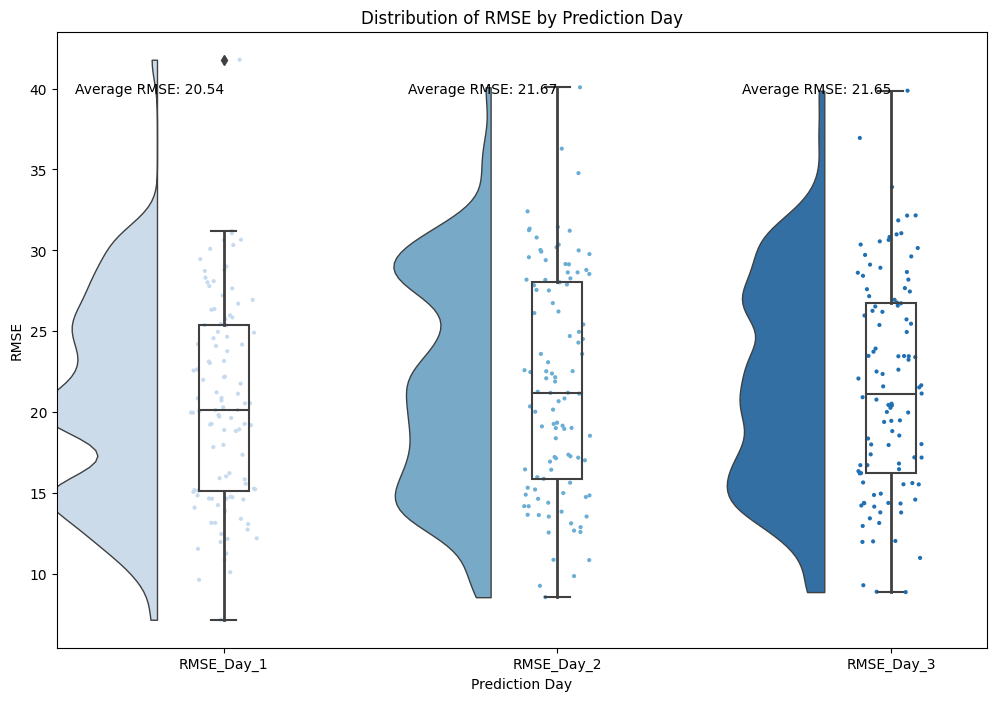

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import ptitprince as pt

# Melting the dataframe for suitable plotting
plot_data = rmse_results.melt(id_vars=['PID'], var_name='Prediction_Day', value_name='RMSE')

# Calculate average MSE for each day
average_mse = plot_data.groupby('Prediction_Day')['RMSE'].mean().reset_index()
average_mse['label'] = average_mse['RMSE'].apply(lambda x: f'Average RMSE: {x:.2f}')

# Creating a raincloud plot
plt.figure(figsize=(12, 8))
ax = pt.RainCloud(data=plot_data, x='Prediction_Day', y='RMSE', palette='Blues', bw=0.2)

# Title and labels
plt.title('Distribution of RMSE by Prediction Day')
plt.xlabel('Prediction Day')
plt.ylabel('RMSE')

# Adding average MSE labels to the plot
for i, row in average_mse.iterrows():
    plt.text(x=i, y=plot_data['RMSE'].max() * .95, s=row['label'], horizontalalignment='right')

plt.show()

## Correlation

In [10]:
from scipy.stats import pearsonr

def calculate_correlation(data, actual, predicted):
    valid_data = data.dropna(subset=[actual, predicted])
    if len(valid_data) < 2:
        return np.nan  # Return NaN if not enough data to calculate correlation
    correlation, _ = pearsonr(valid_data[actual], valid_data[predicted])
    return correlation

# Group by 'PID' and apply the correlation calculation for each prediction day
correlation_results = df.groupby('PID').apply(lambda x: pd.Series({
    'Correlation_Day_1': calculate_correlation(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d1'),
    'Correlation_Day_2': calculate_correlation(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d2'),
    'Correlation_Day_3': calculate_correlation(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d3')
})).reset_index()

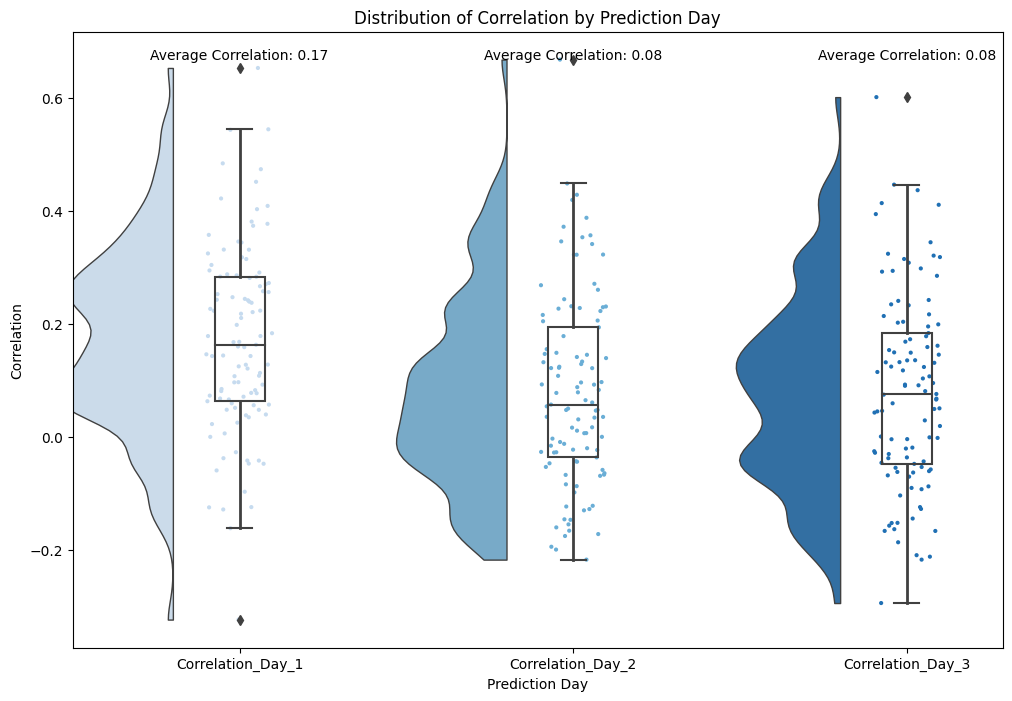

In [11]:
# Melting the dataframe for suitable plotting
plot_data = correlation_results.melt(id_vars=['PID'], var_name='Prediction_Day', value_name='Correlation')

# Calculate average correlation for each day
average_corr = plot_data.groupby('Prediction_Day')['Correlation'].mean().reset_index()
average_corr['label'] = average_corr['Correlation'].apply(lambda x: f'Average Correlation: {x:.2f}')

# Creating a raincloud plot
plt.figure(figsize=(12, 8))
ax = pt.RainCloud(data=plot_data, x='Prediction_Day', y='Correlation', palette='Blues', bw=0.2)

# Title and labels
plt.title('Distribution of Correlation by Prediction Day')
plt.xlabel('Prediction Day')
plt.ylabel('Correlation')

# Adding average correlation labels to the plot
for i, row in average_corr.iterrows():
    plt.text(x=i, y=plot_data['Correlation'].max(), s=row['label'], horizontalalignment='center')

plt.show()

# Mixed Effects Models

## Gap

In [12]:
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
cols = ['PID',
        'trial_date',
        'sr_gap_heuristic',
        'sr_gap_heuristic_d1',
        'sr_gap_heuristic_d2',
        'sr_gap_heuristic_d3'
        ]
df_pred = df[cols].copy()
df_pred.dropna(inplace=True)

results = {}
pred_columns = ['sr_gap_heuristic_d1', 'sr_gap_heuristic_d2', 'sr_gap_heuristic_d3']
for col in pred_columns:
    model = MixedLM(df_pred[col], df_pred[['sr_gap_heuristic']], groups=df_pred['PID'])
    result = model.fit()
    df_pred[col + '_pred'] = result.fittedvalues  # Store predictions for RMSE calculation
    results[col] = result

# Output the summary of one of the models if needed
print(results['sr_gap_heuristic_d1'].summary())

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: sr_gap_heuristic_d1
No. Observations: 6988    Method:             REML               
No. Groups:       105     Scale:              268.4983           
Min. group size:  21      Log-Likelihood:     -29758.8843        
Max. group size:  81      Converged:          Yes                
Mean group size:  66.6                                           
-----------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
sr_gap_heuristic        0.197    0.012 16.561 0.000  0.174  0.220
Group Var            1233.337   10.744                           



In [13]:
rmse_scores = {}
for col in pred_columns:
    actual = df_pred[col].dropna()
    predicted = df_pred[col + '_pred'][actual.index]  # Ensure alignment of indices
    mse = mean_squared_error(actual, predicted)
    rmse_scores[col] = np.sqrt(mse)

# Display the RMSE scores
print(rmse_scores)

{'sr_gap_heuristic_d1': 16.261564564708788, 'sr_gap_heuristic_d2': 16.48465638065982, 'sr_gap_heuristic_d3': 16.33214734067258}


## Gap + Net Affect

In [14]:
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
cols = ['PID',
        'trial_date',
        'sr_gap_heuristic',
        'sr_gap_heuristic_d1',
        'sr_gap_heuristic_d2',
        'sr_gap_heuristic_d3',
        'sr_affect_net_avg'
        ]
df_pred = df[cols].copy()
df_pred.dropna(inplace=True)

results = {}
pred_columns = ['sr_gap_heuristic_d1', 'sr_gap_heuristic_d2', 'sr_gap_heuristic_d3']
for col in pred_columns:
    model = MixedLM(df_pred[col], df_pred[['sr_gap_heuristic', 'sr_affect_net_avg']], groups=df_pred['PID'])
    result = model.fit()
    df_pred[col + '_pred'] = result.fittedvalues  # Store predictions for RMSE calculation
    results[col] = result

# Output the summary of one of the models if needed
print(results['sr_gap_heuristic_d1'].summary())

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: sr_gap_heuristic_d1
No. Observations: 6823    Method:             REML               
No. Groups:       105     Scale:              267.8141           
Min. group size:  16      Log-Likelihood:     -29051.1780        
Max. group size:  81      Converged:          Yes                
Mean group size:  65.0                                           
-----------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
sr_gap_heuristic        0.210    0.013 16.663 0.000  0.186  0.235
sr_affect_net_avg       0.573    0.245  2.340 0.019  0.093  1.053
Group Var            1189.945   10.440                           



In [15]:
rmse_scores = {}
for col in pred_columns:
    actual = df_pred[col].dropna()
    predicted = df_pred[col + '_pred'][actual.index]  # Ensure alignment of indices
    mse = mean_squared_error(actual, predicted)
    rmse_scores[col] = np.sqrt(mse)

# Display the RMSE scores
print(rmse_scores)

{'sr_gap_heuristic_d1': 16.236674085423978, 'sr_gap_heuristic_d2': 16.488029222619012, 'sr_gap_heuristic_d3': 16.273360147514058}


# ML Models

### Feature Engineering

In [16]:
# Example feature engineering: Mean encoding for PIDs
pid_mean = df.groupby('PID')['sr_gap_heuristic'].transform('mean')
df['sr_gap_heuristic_mean'] = pid_mean

pid_mean = df.groupby('PID')['sr_affect_net_avg'].transform('mean')
df['sr_affect_subject_mean'] = pid_mean

df['sr_gap_heuristic_residual'] = df['sr_gap_heuristic'] - df['sr_gap_heuristic_mean']
df['sr_affect_residual'] = df['sr_affect_net_avg'] - df['sr_affect_subject_mean']

In [18]:
cols = ['PID',
        'trial_date',
        'sr_gap_heuristic',
        'sr_gap_heuristic_d1',
        'sr_gap_heuristic_d2',
        'sr_gap_heuristic_d3',
        'sr_affect_net_avg',
        'sr_gap_heuristic_mean',
        'sr_gap_heuristic_residual',
        'sr_affect_subject_mean',
        'sr_affect_residual'
        ]
df_pred = df[cols].copy()
df_pred.dropna(inplace=True)

## Gradient Boosted | Affect + Gap

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1134
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 6
[LightGBM] [Info] Start training from score 42.923862
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[61]	valid_0's rmse: 15.6652	valid_0's l2: 245.399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1126
[LightGBM] [Info] Number of data points in the train set: 5457, number of used features: 6
[LightGBM] [Info] Start training from score 41.638802
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	valid_0's rmse: 17.2657	valid_0's l2: 298.103
[LightGBM] [Info] Auto-c

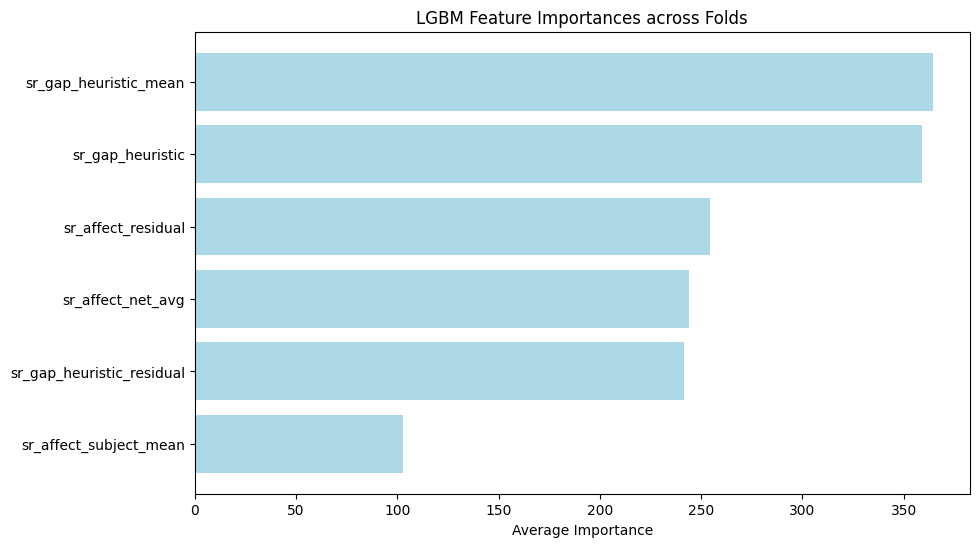

In [23]:
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from lightgbm.callback import early_stopping

# Prepare features and target
X = df_pred[['sr_gap_heuristic', 'sr_affect_net_avg', 'sr_gap_heuristic_mean', 'sr_gap_heuristic_residual', 'sr_affect_subject_mean', 'sr_affect_residual']]  # plus other features as needed
y = df_pred['sr_gap_heuristic_d1']  # Predicting Day 1 gap as an example
groups = df_pred['PID']

# Setup Group K-Fold to respect PID groups
gkf = GroupKFold(n_splits=5)

# Define the model
model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=100)

# Prepare to store feature importances
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

rmse_scores = []

# Perform group k-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        callbacks=[early_stopping(10)]
    )
    
    # Use the best iteration to make predictions
    y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
    
    # Calculate RMSE and append to list
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    # Get feature importances
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = X.columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold + 1
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)


# Output the RMSE scores
print("RMSE scores:", rmse_scores)
print("Average RMSE:", np.mean(rmse_scores))

# Compute average feature importances across all folds
average_importances = feature_importances.groupby('feature').mean().sort_values(by="importance", ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.title('LGBM Feature Importances across Folds')
plt.barh(average_importances.index, average_importances['importance'], color='lightblue')
plt.xlabel('Average Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

## Same Day

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 4
[LightGBM] [Info] Start training from score 42.960721
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[61]	valid_0's rmse: 15.2621	valid_0's l2: 232.933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 616
[LightGBM] [Info] Number of data points in the train set: 5457, number of used features: 4
[LightGBM] [Info] Start training from score 41.624255
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[74]	valid_0's rmse: 17.0831	valid_0's l2: 291.832
[LightGBM] [Info] Auto-cho

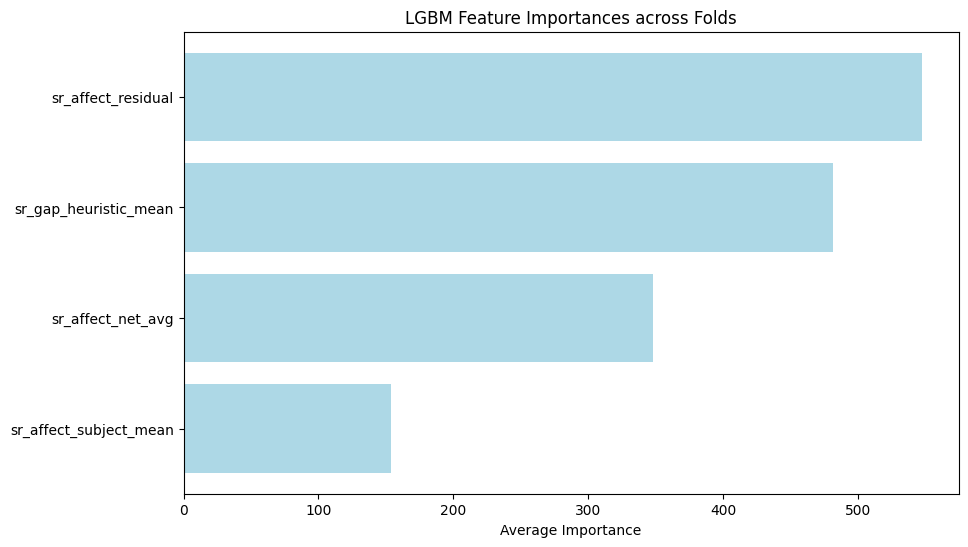

In [26]:
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from lightgbm.callback import early_stopping

# Prepare features and target
X = df_pred[['sr_affect_net_avg', 'sr_gap_heuristic_mean', 'sr_affect_subject_mean', 'sr_affect_residual']]  # plus other features as needed
y = df_pred['sr_gap_heuristic']  # Predicting Day 1 gap as an example
groups = df_pred['PID']

# Setup Group K-Fold to respect PID groups
gkf = GroupKFold(n_splits=5)

# Define the model
model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=100)

# Prepare to store feature importances
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

rmse_scores = []

# Perform group k-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        callbacks=[early_stopping(10)]
    )
    
    # Use the best iteration to make predictions
    y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
    
    # Calculate RMSE and append to list
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    # Get feature importances
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = X.columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold + 1
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)


# Output the RMSE scores
print("RMSE scores:", rmse_scores)
print("Average RMSE:", np.mean(rmse_scores))

# Compute average feature importances across all folds
average_importances = feature_importances.groupby('feature').mean().sort_values(by="importance", ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.title('LGBM Feature Importances across Folds')
plt.barh(average_importances.index, average_importances['importance'], color='lightblue')
plt.xlabel('Average Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

## Location

- Fix timing
- Look at raw data

## Weekly Effects
- mimic the paper Cendri sent?

# Within-Subject Rationale

# PLAN

## Select Subject

In [517]:
sub = 1

subject = np.unique(df.PID)[sub-1]

print(f'Subject {subject} selected.')

Subject 0151d9f1-1644-4437-805e-02f5e244a690 selected.


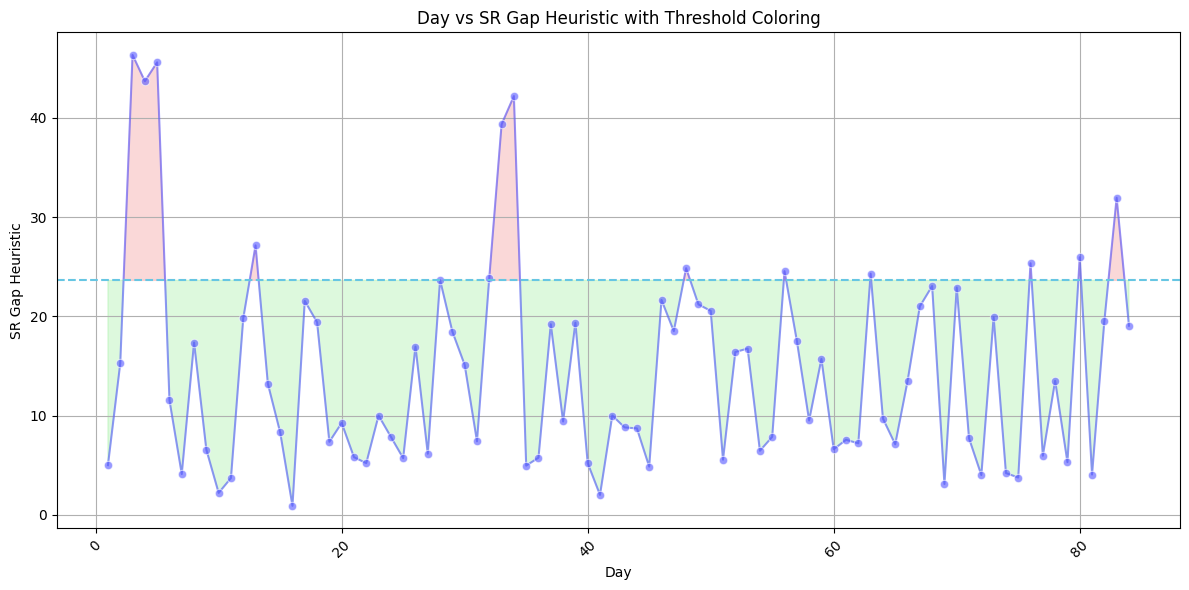

In [518]:
df_sub = df.loc[df.PID == subject]

# Calculate the midpoint value between max and min of sr_gap_heuristic
max_val = df_sub['sr_gap_heuristic'].max()
min_val = df_sub['sr_gap_heuristic'].min()
mid_val = (max_val + min_val) / 2

# Creating the plot
plt.figure(figsize=(12, 6))
# Plotting all data points
sns.lineplot(x='day', y='sr_gap_heuristic', data=df_sub, color="#5356FF", alpha=0.6, marker='o')

# Add a horizontal line at the threshold
plt.axhline(y=mid_val, color='#67C6E3', linestyle='--')
plt.fill_between(df_sub['day'], df_sub['sr_gap_heuristic'], mid_val, where=(df_sub['sr_gap_heuristic'] <= mid_val), 
                 interpolate=True, color='lightgreen', alpha=0.3)
plt.fill_between(df_sub['day'], df_sub['sr_gap_heuristic'], mid_val, where=(df_sub['sr_gap_heuristic'] > mid_val), 
                 interpolate=True, color='lightcoral', alpha=0.3)

plt.title('Day vs SR Gap Heuristic with Threshold Coloring')
plt.xlabel('Day')
plt.ylabel('SR Gap Heuristic')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Data Cleaning

In [519]:
# Convert all columns to numeric, setting errors='coerce' will convert non-convertible values to NaN
df_numeric = df.loc[df.PID == subject].apply(pd.to_numeric, errors='coerce')

In [547]:
X = df_numeric.copy()

### Extract Categorical Features

In [579]:
cat_cols = ['day_of_week', 'task_nback_mode']
X.drop(columns=cat_cols, inplace=True)

KeyError: "['day_of_week', 'task_nback_mode'] not found in axis"

### Remove Extraneous Features

In [549]:
# Remove app/web columns for device usage as these are then totaled
web_cols = [col for col in X.columns if 'passive_sk_device_web_usage' in col]
app_cols = [col for col in X.columns if 'passive_sk_device_app_usage' in col]

X.drop(columns=web_cols, inplace=True)
X.drop(columns=app_cols, inplace=True)

In [550]:
# Remove trial date - using day
X.drop(columns='trial_date', inplace=True)

In [551]:
# remove existing residual columns since we will be calculating differences/residuals for all columns
cols = [col for col in X.columns if 'residual' in col]
X.drop(columns=cols, inplace=True)

In [552]:
# z scored some rts, can remove those
cols = [col for col in X.columns if 'rt_z' in col]
X.drop(columns=cols, inplace=True)

In [553]:
# remove keyboard sentiment for emoji and word individually since they are combined
cols = [col for col in X.columns if 'keyboard_sentiment_emoji' in col]
X.drop(columns=cols, inplace=True)

In [554]:
# remove keyboard sentiment for emoji and word individually since they are combined
cols = [col for col in X.columns if 'keyboard_sentiment_word' in col]
X.drop(columns=cols, inplace=True)

In [555]:
# remove device sentiment as this is an error
cols = [col for col in X.columns if 'device_sentiment' in col]
X.drop(columns=cols, inplace=True)

In [556]:
# Remove heuristic gap components
heuristic_gap_cols = ['sr_DAILY_past24_gap', 'sr_DAILY_goal1_report', 'sr_DAILY_goal2_report', 'sr_DAILY_past24_values']

X.drop(columns=heuristic_gap_cols, inplace=True)

# Remove simple gap which is just sr_DAILY_past24_gap
X.drop(columns='sr_gap_simple', inplace=True)

### Remove Features Over NA Threshold

In [557]:
# Remove columns with NaN counts about threshold
threshold_nan = 0.5

nan_counts = X.isna().sum()
cols_to_drop_due_to_nans = nan_counts[nan_counts > len(X) * threshold_nan].index
X = X.drop(columns=cols_to_drop_due_to_nans)

print(f'Removed {len(cols_to_drop_due_to_nans)} features due to NaNs:\n')
for item in cols_to_drop_due_to_nans:
    print(item)

Removed 99 features due to NaNs:

PID
affect_pct_zeroVarRows
affect_zeroVarRows_flag
sr_DAILY_goal1_interaction_month
sr_DAILY_goal1_interaction_week
sr_DAILY_goal1_set
sr_DAILY_goal2_interaction_month
sr_DAILY_goal2_interaction_week
sr_DAILY_goal2_set
sr_DAILY_next24_drinks
sr_DAILY_next24_leisureNonSolo
sr_DAILY_next24_leisureSolo
sr_DAILY_next24_nonoccupation
sr_DAILY_next24_socialMedia
sr_DAILY_past24_diet
sr_DAILY_past24_gapCause
sr_DAILY_past48to24_gap
sr_DAILY_past48to24_gapCause
sr_DAILY_survey_missed
sr_DAILY_survey_situation1_surveys
sr_DAILY_survey_situation2_surveys
sr_IDEAL_values_monthly1
sr_IDEAL_values_monthly2
sr_IDEAL_values_monthly3
sr_MONTHLY_goal_set1
sr_MONTHLY_goal_set2
sr_WEEKLY_goal_set1
sr_WEEKLY_goal_set2
sr_DAILY_past48to24_gapCause_internal
sr_DAILY_past48to24_gapCause_external
sr_DAILY_gap_diet
sr_DAILY_gap_nonoccupation
sr_DAILY_gap_leisureSolo
sr_DAILY_gap_leisureNonSolo
sr_DAILY_gap_socialMedia
sr_DAILY_gap_drinks
task_motivation_time
task_gng_time
task

In [558]:
# Remove columns with almost no variance

# First scale using Min-Max Normalization
X = (X-X.min())/(X.max()-X.min())

# Set threshold
var_threshold = .01

no_var_cols = X.loc[:, np.var(X) <= var_threshold].columns
## X = X.loc[:, np.var(X) > var_threshold]

print(f'\nRemoved {len(no_var_cols)} features due to Var <= {var_threshold}:\n')
for item in no_var_cols:
    print(item)


Removed 0 features due to Var <= 0.01:



In [559]:
# if the max and min value were the same var = NaN...remove these

nan_counts = X.isna().sum()
cols_to_drop_due_to_nans = nan_counts[nan_counts > len(X) * threshold_nan].index
X = X.drop(columns=cols_to_drop_due_to_nans)

print(f'Removed {len(cols_to_drop_due_to_nans)} features due to NaNs:\n')
for item in cols_to_drop_due_to_nans:
    print(item)

Removed 55 features due to NaNs:

affect_neg_lonelyIsolated_am
affect_zeroVar_cols
affect_zeroVarCols_flag
sr_DAILY_past24_drinks
sr_DAILY_past24_leisureSoloPhysical
sr_dailySR_zeroVar_cols
sr_dailySR_zeroVarCols_flag
task_nback_trialCount
task_psat_flag_sub100RT_n
task_psat_flag_3plusRT_n
task_hanoi_solved
task_rt_flag_plus2_n
passive_sk_visits_home_distance
passive_sk_visits_gym_elapsed
passive_sk_visits_school_elapsed
passive_sk_visits_unknown_distance_flag
task_hanoi_movesTime_model_startPoint
task_hanoi_movesTime_model_decay
task_hanoi_movesTime_model_asymptote
task_psat_effciency_model_intercept
task_psat_effciency_model_slope
task_stroop_effciency_model_intercept
task_stroop_effciency_model_slope
task_bart_score_model_intercept
task_bart_score_model_slope
task_spatialSpan_score_model_intercept
task_spatialSpan_score_model_slope
task_emoStroop_trying
task_emoStroop_efficiency_model_intercept
task_emoStroop_efficiency_model_slope
task_gng_trying
task_gng_d_prime_model_intercept
ta

In [560]:
X.shape

(85, 254)

### Remove Features Over Correlation Threshold

**Notes**

> in `.corr()` Pearson, Kendall and Spearman correlation are currently computed using pairwise complete observations.

> in `.corr()` the `min_periods` parameter indicates the minimum number of observations required per pair of columns to have a valid result.

In [561]:
# Compute the correlation matrix - need at least 20 values
corr_matrix = X.corr(method='pearson', min_periods=20).abs()

In [562]:
# there are some nan columns as the min 20 periods do not line up for all variables...
corr_matrix.isna().sum().sum()

44

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


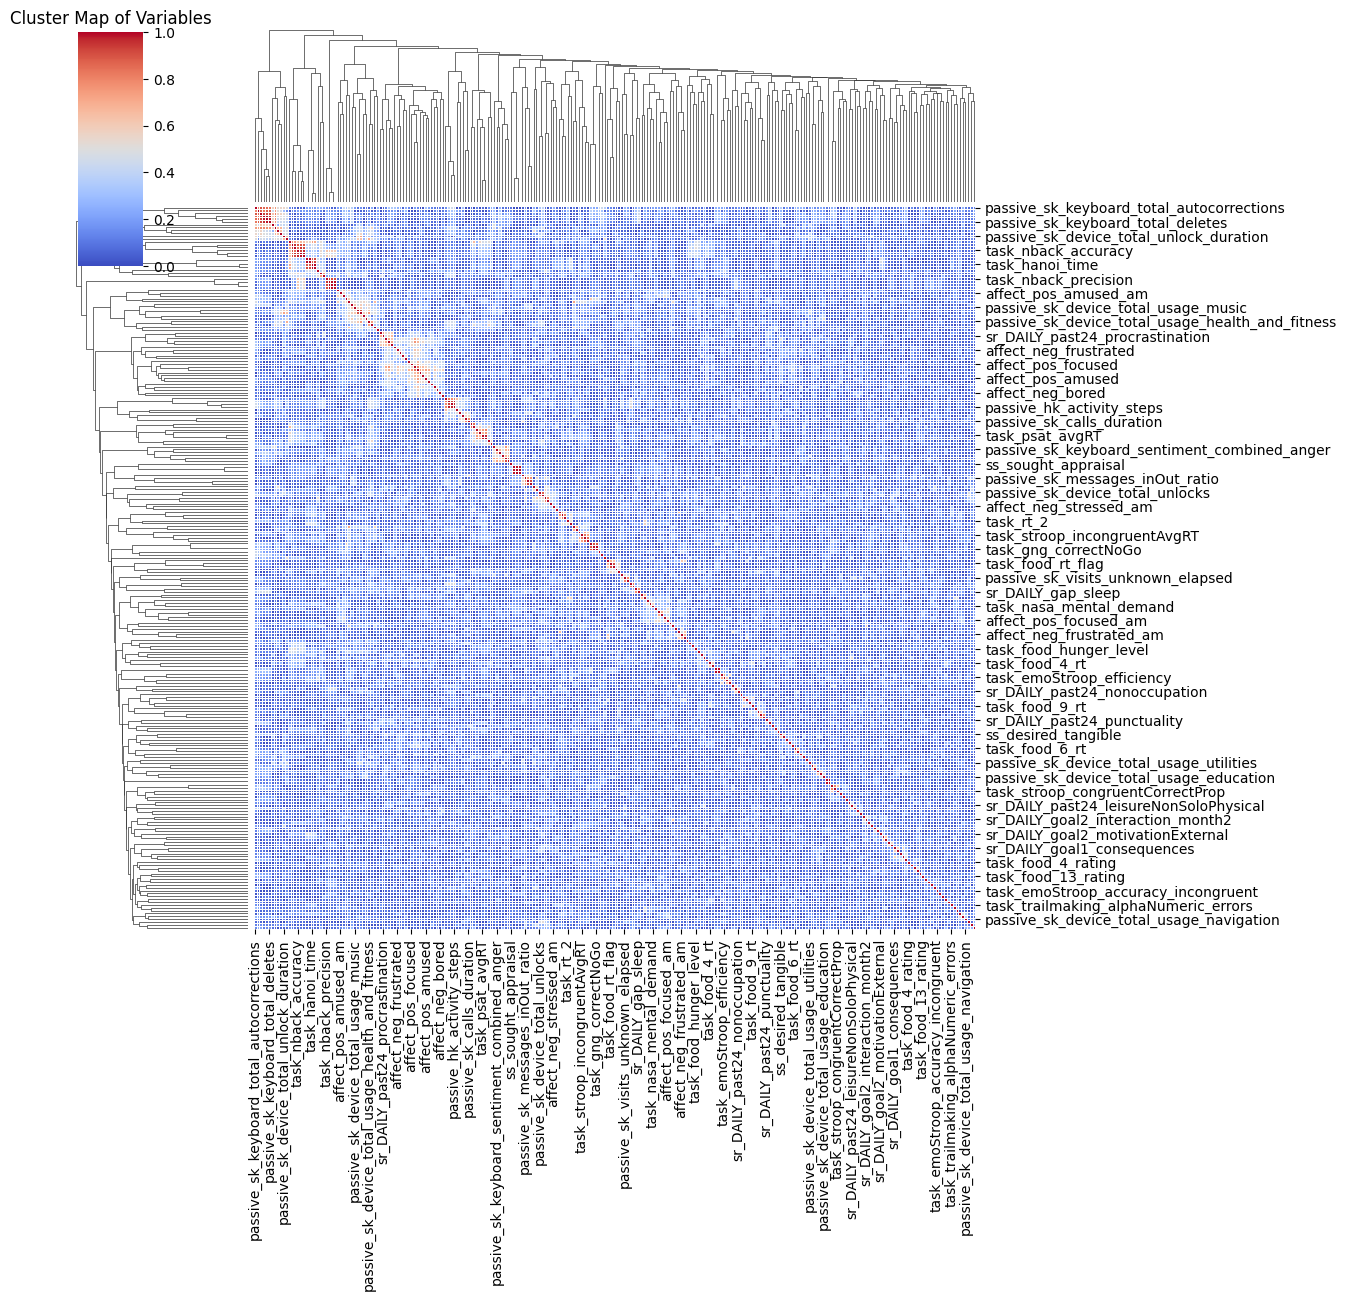

In [563]:
# fill Na values in corr matrix
corr_matrix = corr_matrix.fillna(0)

sns.clustermap(corr_matrix, figsize=(13, 13), cmap='coolwarm', linewidths=.5)
plt.title('Cluster Map of Variables')
plt.show()

In [564]:
# Define the threshold
threshold = 0.95

# Create a mask to find correlations greater than the threshold, ignoring the diagonal
mask = abs(corr_matrix) > threshold
np.fill_diagonal(mask.values, False)

# Extract pairs above threshold
high_corr_pairs = corr_matrix[mask].stack()

# Format the output for better readability
formatted_pairs = pd.DataFrame(high_corr_pairs).reset_index()
formatted_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
formatted_pairs = formatted_pairs.drop_duplicates(subset=['Correlation'])

formatted_pairs #.sort_values(by='Correlation', ascending=False)

Variable 1  \
0            sr_DAILY_past24_gapCause_internal   
6                        task_bart_total_pumps   
9                         task_bart_unpopped_n   
12                           task_nback_missed   
13                       task_nback_falseAlarm   
14                       task_nback_falseAlarm   
15                       task_nback_falseAlarm   
16                         task_nback_accuracy   
19                           task_nback_recall   
21                      task_nback_specificity   
25                               task_nback_F1   
28                             task_psat_avgRT   
29                             task_hanoi_time   
32          passive_hk_activity_appleStandTime   
33  passive_hk_activity_distanceWalkingRunning   
36             passive_sk_keyboard_total_words   
37             passive_sk_keyboard_total_words   
39   passive_sk_keyboard_total_typing_duration   

                                   Variable 2  Correlation  
0           sr_DAILY_past24_gapCause_external     1.000000  
6                        task_bart_unpopped_n     0.984944  
9                             task_bart_score     0.984944  
12                          task_nback_recall     0.955860  
13                       task_nback_precision     0.953496  
14                     task_nback_specificity     0.994314  
15                  task_nback_falseAlarmRate     0.994314  
16                             task_nback_MCC     0.973813  
19                              task_nback_F1     0.953046  
21                  task_nback_falseAlarmRate     1.000000  
25                             task_nback_MCC     0.986979  
28                       task_psat_efficiency     0.975667  
29                       task_hanoi_movesTime     0.997676  
32                  passive_hk_activity_steps     0.969577  
33                  passive_hk_activity_steps     0.976992  
36  passive_sk_keyboard_total_typing_duration     0.981887  
37          passive_sk_keyboard_total_deletes     0.961767  
39          passive_sk_keyboard_total_deletes     0.981055

In [565]:
# Identify pairs of highly correlated features
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

In [566]:
to_drop

['sr_DAILY_past24_gapCause_external',
 'task_gng_correctGo',
 'task_gng_correctNoGo',
 'task_bart_unpopped_n',
 'task_bart_score',
 'task_nback_precision',
 'task_nback_recall',
 'task_nback_specificity',
 'task_nback_falseAlarmRate',
 'task_nback_F1',
 'task_nback_MCC',
 'task_hanoi_extraMoves',
 'passive_hk_activity_steps',
 'passive_sk_keyboard_total_typing_duration',
 'passive_sk_keyboard_total_deletes',
 'task_hanoi_movesTime',
 'task_psat_efficiency']

In [567]:
# Drop highly correlated columns
X = X.drop(to_drop, axis=1)

In [568]:
X.shape

(85, 237)

# Feature Engineering
- window stats (e.g. 3 day, 7 day)
    - mean, SD, min, max
- `delta` features
    - day to day differences
    - day to week

### Rolling Average, Lags and Diffs

For each column calculate:

- 3 and 7 day rolling average (up to current day)
- Expanding average (1st day to current day)
- 7 day variance (up to current day)
- 1, 2 and 3 day lags of each feature
- Difference between 3, 7 and expanding average and current day

In [569]:
# Get numeric columns only for processing
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Dictionary to hold new columns
new_columns = {}

# Calculate rolling averages and store in the dictionary
for col in numeric_cols:
    for window in [3, 7]:
        rolling_col = X[col].rolling(window=window, min_periods=1).mean()  # use min_periods=1 to ensure output
        new_columns[f'{col}_rolling_mean_{window}'] = rolling_col
        new_columns[f'{col}_exponential_rolling_mean_{window}'] = X[col].ewm(span=window).mean()

# Calculate rolling mean including the current row for each numeric column
for col in numeric_cols:
    new_columns[f'{col}_rolling_mean_expanding'] = X[col].expanding(min_periods=1).mean()
        
# Calculate dynamically adjusted EMA
def dynamically_adjusted_ema(series):
    emas = []
    ema = series.iloc[0]  # initialize EMA with the first data point
    emas.append(ema)
    for t in range(1, len(series)):
        alpha_t = 2 / (t + 1 + 1)  # dynamically adjust alpha
        ema = alpha_t * series.iloc[t] + (1 - alpha_t) * ema
        emas.append(ema)
    return pd.Series(emas, index=series.index)
for col in numeric_cols:
    new_columns[f'{col}_exponential_rolling_mean_expanding'] = dynamically_adjusted_ema(X[col])
        
# Calculate rolling variance
for col in numeric_cols:
    for window in [7]:
        rolling_col = X[col].rolling(window=window, min_periods=1).var()  # use min_periods=1 to ensure output
        new_columns[f'{col}_rolling_var_{window}'] = rolling_col

# Generate lag features and store in dictionary
for col in numeric_cols:
    for lag in [1, 2, 3]:
        new_columns[f'{col}_lag_{lag}'] = X[col].shift(lag)

# Add new_columns to X before calculating differences to ensure all columns exist
X = pd.concat([X, pd.DataFrame(new_columns)], axis=1)

# Dictionary to hold new columns
new_columns = {}

# Store differences from rolling averages to mean and from current day value to mean
for col in numeric_cols:
    new_columns[f'{col}_diff_rolling_mean_3_day'] = X[col] - X[f'{col}_rolling_mean_3'] 
    new_columns[f'{col}_diff_rolling_mean_7_day'] = X[col] - X[f'{col}_rolling_mean_7']

# Store differences from the expanding mean
for col in numeric_cols:
    new_columns[f'{col}_diff_to_expanding_mean'] = X[col] - X[f'{col}_rolling_mean_expanding']
    
# Add new_columns to X
X = pd.concat([X, pd.DataFrame(new_columns)], axis=1)

In [572]:
X.head()

affect_neg_angry  affect_neg_ashamed  affect_neg_bored  \
0              0.25            0.000000              0.25   
1              0.25            0.000000              0.00   
2              0.00            0.666667              0.50   
3              0.25            0.000000              0.25   
4              0.00            0.000000              0.00   

   affect_neg_depressed  affect_neg_embarrassed  affect_neg_frustrated  \
0                  0.00                     0.0                   0.00   
1                  0.00                     0.0                   0.00   
2                  0.50                     1.0                   0.00   
3                  0.25                     0.0                   0.25   
4                  0.00                     0.0                   0.00   

   affect_neg_guilty  affect_neg_lazy  affect_neg_lonelyIsolated  \
0                0.0             0.25                        0.0   
1                0.0             0.00                        0.0   
2                0.0             0.25                        1.0   
3                0.0             0.25                        0.0   
4                0.0             0.75                        0.0   

   affect_neg_nervousAnxious  ...  \
0                       0.00  ...   
1                       0.75  ...   
2                       0.75  ...   
3                       0.25  ...   
4                       0.00  ...   

   passive_sk_device_total_usage_music_diff_to_expanding_mean  \
0                                           0.000000            
1                                           0.105348            
2                                          -0.153431            
3                                          -0.083468            
4                                           0.381848            

   passive_sk_device_total_usage_navigation_diff_to_expanding_mean  \
0                                                0.0                 
1                                                0.0                 
2                                                0.0                 
3                                                0.0                 
4                                                0.0                 

   passive_sk_device_total_usage_news_diff_to_expanding_mean  \
0                                                0.0           
1                                                0.0           
2                                                0.0           
3                                                0.0           
4                                                0.0           

   passive_sk_device_total_usage_photo_and_video_diff_to_expanding_mean  \
0                                           0.000000                      
1                                          -0.475926                      
2                                          -0.170229                      
3                                          -0.234933                      
4                                          -0.252468                      

   passive_sk_device_total_usage_productivity_diff_to_expanding_mean  \
0                                           0.000000                   
1                                          -0.015715                   
2                                           0.309950                   
3                                           0.177249                   
4                                           0.318879                   

   passive_sk_device_total_usage_social_networking_diff_to_expanding_mean  \
0                                           0.000000                        
1                                           0.281121                        
2                                          -0.293147                        
3                                          -0.190606                        
4                                          -0.155523                        

   passive_sk_d

### Dummy Code Categorical Features

In [617]:
X['sr_gap_heuristic']

0     0.090209
1     0.315732
2     1.000000
3     0.941694
4     0.983498
        ...   
80    0.069307
81    0.409241
82    0.683168
83    0.399340
84         NaN
Name: sr_gap_heuristic, Length: 85, dtype: float64

In [597]:
cat_df = df_sub[cat_cols]
cat_df.head()

day_of_week task_nback_mode
0            0            hard
1            1            hard
2            2            hard
3            3            hard
4            4            easy

In [598]:
# Dictionary mapping integers to weekday names
weekdays = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Use the map function to convert integers to weekday names
cat_df['day_of_week'] = cat_df['day_of_week'].map(weekdays)

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_14390/54949847.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['day_of_week'] = cat_df['day_of_week'].map(weekdays)


In [599]:
# Dummy coding
# Convert to dummy variables without dropping any column
cat_df_dummies = pd.get_dummies(cat_df, drop_first=False)

# Explicitly drop the column for the baseline category
cat_df_dummies.drop('day_of_week_Monday', axis=1, inplace=True)

# Explicitly drop the column for the baseline category
cat_df_dummies.drop('task_nback_mode_easy', axis=1, inplace=True)

cat_df_dummies.head()

day_of_week_Friday  day_of_week_Saturday  day_of_week_Sunday  \
0               False                 False               False   
1               False                 False               False   
2               False                 False               False   
3               False                 False               False   
4                True                 False               False   

   day_of_week_Thursday  day_of_week_Tuesday  day_of_week_Wednesday  \
0                 False                False                  False   
1                 False                 True                  False   
2                 False                False                   True   
3                  True                False                  False   
4                 False                False                  False   

   task_nback_mode_hard  
0                  True  
1                  True  
2                  True  
3                  True  
4                 False

In [600]:
# Add categorical columns to X (not using dummies at this point)
X = pd.concat([X, cat_df], axis=1)

In [601]:
X.shape

(85, 3320)

In [615]:
X.drop(columns=cat_df.columns, inplace=True)

In [605]:
# next day gap
y = X['sr_gap_heuristic'].shift(-1).dropna() # remove trailing NaN
y2 = X['sr_gap_heuristic'].shift(-2).dropna()
y3 = X['sr_gap_heuristic'].shift(-3).dropna()

In [604]:
X.to_csv('X.csv', index=False)

# Feature Selection

In [616]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

y_fs = X['sr_gap_heuristic'].shift(-1)       # Target variable shifted forward by 1
X_fs = X.iloc[:-1, :]  # Remove the last row because of NaN target
y_fs = y_fs[:-1]      # Remove the last NaN

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, y_fs, test_size=0.2, random_state=42)

# Initialize and fit the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X_fs.columns
forest_importances = pd.Series(importances, index=feature_names)

# Plot feature importances
forest_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5))
plt.title('Feature Importances using Random Forest')
plt.show()

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Additional Methods

## Two-Part Modeling

https://www.statmodel.com/download/DSEMFloorEffects.pdf

## Rolling Window Analysis
### Feature Engineering
- Local Statistics within the window

```
Rolling window cross-validation, also known as sliding or moving window cross-validation, is specifically designed for time-series data. It systematically shifts the training and validation sets forward in time, maintaining their relative position to one another, to simulate real-world scenarios where a model predicts future values based on past data.

How It Works:
Define Window Sizes:

Training Window: The amount of data included in each training set.
Validation Window: The amount of data used for validation in each iteration. This is usually much smaller than the training window.
Initialize Starting Point:

The initial model is trained on the first segment of the data (from the start up to a predefined point), and predictions are made over the next segment defined by the validation window.
Slide Windows Forward:

For each subsequent iteration, the training and validation windows are both shifted forward by a predefined step (often the size of the validation window). This progression mimics how the model would be used in practice, making predictions as new data becomes available.
Repeat Until Data Exhausted:

This process is repeated until the entire dataset has been used, or until enough iterations have been completed to satisfy the validation strategy.
Aggregate Results:

The performance metrics (like RMSE, MAE, AUC, etc.) are collected from each validation window and are typically summarized (e.g., averaged) to provide an overall assessment.
```

### Various ML Strategies
- Linear Regression
- XG Boost

## Ensemble models
Treat like MLM where the weighting of the models are the parameters

## Causality